## Milestone 1: Lyrics classification

You will implement a text classifier that classifies song lyrics by era.

You are expected to work on this milestone in lab 4-6.

In particular, we created a dataset for you that consists of song lyrics from *rock bands* spanning the last half century!

<img src="pics/cover.jpg">

*This assignment is adapted from material by J.Eisenstein*




# 0. Setup

As for the last assignment,  you will need [python 3.6](https://www.python.org/downloads/) and the following libraries. Most if not all of these are part of [anaconda](https://www.continuum.io/downloads), so a good starting point would be to install that. 

- [jupyter](http://jupyter.readthedocs.org/en/latest/install.html)
- numpy (This will come if you install scipy like above, but if not install separately)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [nosetests](https://nose.readthedocs.org/en/latest/)
- [pandas](http://pandas.pydata.org/) Dataframes

Make sure you have those installed both on your local computer and on your dedicated compute machine (assigned to you in lab 1).


**Fork the repository** Fork the [course material repository](https://github.itu.dk/bapl/2ndyearproject-2019-material), i.e., create your own local copy in your own git repository. Develop your solution there. In the end, upload to the [shared course repository](https://github.itu.dk/bapl/2ndyearproject-2019) (where you uploaded your keys).

In [1]:
## what is your course username? 
## Replace XX with your assigned number
username="dsproj017"

## About this assignment

The assignment setup is similar to your language model assignment, i.e., 
- This is a Jupyter notebook. 
- Most of your coding will be in the python source files in the directory ```snlp```.
- The directory ```tests``` contains unit tests which you should run to see that you're on the right track. 
- You may want to add more tests, but that is completely optional. 
- Code locally, push to your git repository and consider running computationally heavier parts on the assigned compute server.

In [2]:
import sys
from importlib import reload

In [3]:
print('My Python version')

print('python: {}'.format(sys.version))

My Python version
python: 3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [4]:
import nose

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import keras

%matplotlib inline

Using TensorFlow backend.


In [5]:
print('My library versions')

print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(sp.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('nose: {}'.format(nose.__version__))
print('keras: {}'.format(keras.__version__))

My library versions
pandas: 0.23.4
numpy: 1.15.4
scipy: 1.2.0
matplotlib: 2.2.3
nose: 1.3.7
keras: 2.2.4


To test whether your libraries are the right version, run:

In [6]:
# use ! to run shell commands in notebook
! nosetests tests/test_environment.py

Using TensorFlow backend.
F
FAIL: test_environment.test_library_versions
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/davidmortensen/anaconda3/lib/python3.7/site-packages/nose/case.py", line 197, in runTest
    self.test(*self.arg)
  File "/Users/davidmortensen/2ndyearproject/Milestone1/tests/test_environment.py", line 30, in test_library_versions
    ok_(LooseVersion(sys.version) < LooseVersion(max_python)) # make sure not to use py3.7
AssertionError: None
-------------------- >> begin captured logging << --------------------
matplotlib: DEBUG: $HOME=/Users/davidmortensen
matplotlib: DEBUG: matplotlib data path /Users/davidmortensen/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data
matplotlib: DEBUG: loaded rc file /Users/davidmortensen/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
matplotlib: DEBUG: matplotlib version 2.2.3
matplotlib: DEBUG: interactive is False
matplotlib: D

To avoid long debug messages when running in the shell:

```
nosetests tests/test_environment.py --nologcapture --nocapture
```

# 1. Preprocessing


Read the data into a dataframe

In [6]:
df_train = pd.read_csv('data/rock-lyrics-train.csv')

A dataframe is a structured representation of your data. You can preview a dataframe using `head()`

In [7]:
df_train.head()

,Era,Lyrics
0,2000s,Don't tell me what to think 'Cause I don't car...
1,2000s,Whenever the lights go down That's when she co...
2,2000s,You say this will be alright Just put my faith...
3,2000s,There's one who takes it all And there's one w...
4,2000s,So far away from knowing where I am going I am...


## Bags of words

Your first task is to convert the text to a bag-of-words representation. For this data, a lot of the preprocessing is already done: the text is lower-cased, and punctuation is removed. You need only create a `counter` for each instance.

- **Deliverable 1.1**: Complete the function `snlp.preproc.bag_of_words`. 
- **Test**: `nosetests tests/test_preproc.py:test_d1_1_bow`

In [8]:
from snlp import preproc

In [9]:
# run this block to update the notebook as you change the preproc library
reload(preproc);

In [14]:
! nosetests tests/test_environment.py

Using TensorFlow backend.
F
FAIL: test_environment.test_library_versions
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/davidmortensen/anaconda3/lib/python3.7/site-packages/nose/case.py", line 197, in runTest
    self.test(*self.arg)
  File "/Users/davidmortensen/2ndyearproject/Milestone1/tests/test_environment.py", line 30, in test_library_versions
    ok_(LooseVersion(sys.version) < LooseVersion(max_python)) # make sure not to use py3.7
AssertionError: None
-------------------- >> begin captured logging << --------------------
matplotlib: DEBUG: $HOME=/Users/davidmortensen
matplotlib: DEBUG: matplotlib data path /Users/davidmortensen/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data
matplotlib: DEBUG: loaded rc file /Users/davidmortensen/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
matplotlib: DEBUG: matplotlib version 2.2.3
matplotlib: DEBUG: interactive is False
matplotlib: D

In [11]:
y_tr,x_tr = preproc.read_data('data/rock-lyrics-train.csv', preprocessor = preproc.bag_of_words)
y_dv,x_dv = preproc.read_data('data/rock-lyrics-dev.csv', preprocessor = preproc.bag_of_words)

In [12]:
y_te,x_te = preproc.read_data('data/rock-lyrics-test-hidden.csv', preprocessor = preproc.bag_of_words)

## Unseen words

One challenge for classification is that words will appear in the test data that do not appear in the training data. Compute the number of words that appear in `rock-lyrics-dev.csv`, but not in `rock-lyrics-train.csv`. To do this, implement the following deliverables:

- **Deliverable 1.2**: implement `snlp.preproc.aggregate_counts`, a counter of all words in a list of bags-of-words. 
- **Deliverable 1.3**: implement `snlp.preproc.compute_oov`, returning a list of words that appear in one list of bags-of-words, but not another.  
- **Tests**: `tests/test_preproc.py:test_d1_2_agg`, `tests/test_preproc.py:test_d1_3a_oov`

In [15]:
from collections import Counter

In [16]:
reload(preproc);

To write fast code, you can find bottlenecks using the %%timeit cell magic. 

Here I'm evaluating two different implementations of `aggregate_counts`

In [17]:
%%timeit
preproc.aggregate_counts(x_tr)

151 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
counts_dv = preproc.aggregate_counts(x_dv)

You can see the most common items in a counter by calling counts.most_common()`:

In [19]:
counts_dv.most_common(5)

[('the', 4678), ('I', 4005), ('you', 3456), ('to', 2628), ('a', 2363)]

In [20]:
counts_tr = preproc.aggregate_counts(x_tr)

In [21]:
len(preproc.compute_oov(counts_dv,counts_tr))

3145

In [22]:
len(preproc.compute_oov(counts_tr,counts_dv))

33146

In [23]:
preproc.oov_rate(counts_dv,counts_tr)

0.2723651164804711

27% of the words in the dev set do not appear in the training set.

## Power laws

Word count distributions are said to follow [power law](https://en.wikipedia.org/wiki/Power_law) distributions. 

In practice, this means that a log-log plot of frequency against rank is nearly linear. Let's see if this holds for our data.

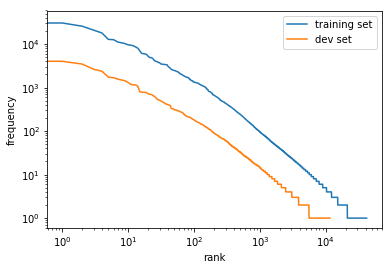

In [24]:
plt.loglog([val for word,val in counts_tr.most_common()])
plt.loglog([val for word,val in counts_dv.most_common()])
plt.xlabel('rank')
plt.ylabel('frequency')
plt.legend(['training set','dev set']);

How would this curve look like if it were not plotted in log space?

## Pruning the vocabulary

Let's prune the vocabulary to include only words that appear at least ten times in the training data.

- **Deliverable 1.4:** Implement `preproc.prune_vocabulary` 
- **Test**: `tests/test_preproc.py:test_d1_4_prune`

In [25]:
reload(preproc);

In [26]:
x_tr_pruned, vocab = preproc.prune_vocabulary(counts_tr,x_tr,10)
x_dv_pruned, _ = preproc.prune_vocabulary(counts_tr,x_dv,10)
x_te_pruned, _ = preproc.prune_vocabulary(counts_tr,x_te,10)

In [27]:
len(vocab)

5992

# 2. Linear classification

Now you'll implement the linear classification rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

You will use these functions in all classifiers in this assignment.



In [28]:
from snlp import clf_base
reload(clf_base)

from snlp import constants
reload(constants);

*Recall from class and the reading that the feature function vector $f(x,y)$ can be viewed as a dict, in which the values are counts, and the keys are tuples $(y,x_j)$, where $y$ is a label and $x_j$ is a base feature.

- **Deliverable 2.1**: Implement the function ```make_feature_vector``` in ```clf_base.py```. 
- **Test**: `tests/test_classifier.py:test_d2_1_featvec`

Note that you must also include the offset feature, ```snlp.constants.OFFSET```.

Desired output is shown below:

In [97]:
! nosetests tests/test_classifier.py:test_d2_1_featvec

Using TensorFlow backend.
.
----------------------------------------------------------------------
Ran 1 test in 1.749s

OK


In [29]:
fv = clf_base.make_feature_vector({'test':1,'case':2},'1980s')

In [30]:
print(fv)

{('1980s', '**OFFSET**'): 1, ('1980s', 'test'): 1, ('1980s', 'case'): 2}


Let's compute the entire set of labels.

In [31]:
labels = set(y_tr) #figure out all possible labels
print(labels)

{'1980s', '1990s', 'pre-1980s', '2000s'}


Now implement the prediction rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

- **Deliverable 2.2**: Implement the function ```predict``` in ```clf_base.py```. (1 point for 4650, 0.5 points for 7650)
- **Test**: `tests/test_classifier.py:test_d2_2_predict`

The output should be:

- A predicted label
- The scores of all labels

This function will be called **a lot**, so try to make it fast. You don't need to do anything crazy, but avoid making your code do silly extra work. It's worth trying out a couple different versions using %%timeit.

You can test this function using these simple hand-crafted weights.

In [32]:
from collections import defaultdict

In [33]:
# weight vectors must be defaultdicts
theta_hand = defaultdict(float,
                         {('2000s','money'):0.1,
                          ('2000s','name'):0.2,
                          ('1980s','tonight'):0.1,
                          ('2000s','man'):0.1,
                          ('1990s','fly'):0.1,
                          ('pre-1980s',constants.OFFSET):0.1
                         })

In [34]:
clf_base.predict(x_tr_pruned[0],theta_hand,labels)

('pre-1980s', {'1980s': 0.0, '1990s': 0.0, 'pre-1980s': 0.1, '2000s': 0.0})

Now let's see how good these weights are, by evaluating on the dev set.

In [35]:
from snlp import evaluation
reload(evaluation);

In [36]:
# this applies your predict function to all the instances in ```x_dv```
y_hat = clf_base.predict_all(x_dv_pruned,theta_hand,labels)
print(evaluation.acc(y_hat,y_dv))

0.30544747081712065


# 3. Naive Bayes

You'll now implement a Naive Bayes classifier.


In [83]:
from snlp import naive_bayes
reload(naive_bayes);

- **Deliverable 3.1**: (warmup) implement ```get_corpus_counts``` in ```naive_bayes.py```. (0.5 points)
- **Test**: `tests/test_classifier.py:test_d3_1_corpus_counts`

This function should compute the word counts for a given label.

In [38]:
eighties_counts = naive_bayes.get_corpus_counts(x_tr_pruned,y_tr,"1980s");
print(eighties_counts['today'])
print(eighties_counts['yesterday'])

24
8


- **Deliverable 3.2**: Implement ```estimate_pxy``` in ```naive_bayes.py```. 
- **Test**: `tests/test_classifier.py:test_d3_2_pxy`

This function should compute the *smoothed* multinomial distribution $\log P(x \mid y)$ for a given label $y$.

Hint: note that this function takes the vocabulary as an argument. You have to assign a probability even for words that do not appear in documents with label $y$, if they are in the vocabulary.

You can use ```get_corpus_counts``` in this function if you want to, but you don't have to.

In [ ]:
! nosetests tests/test_classifier.py:test_d3_2_pxy

In [39]:
d = {'at': 499.60000000000895, 'ah': 169.59999999999795}

sum(d.values())

669.2000000000069

In [40]:
log_pxy = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",0.1,vocab)

Probabilities must sum to one! (or very close)

In [41]:
sum(np.exp(list(log_pxy.values())))

0.9999999999999802

Let's look at the log-probabilities of the words from the hand-tuned weights

In [42]:
print({word:log_pxy[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -7.969973834156985, 'name': -7.377406759792738, 'tonight': -6.9382388281494505, 'man': -6.3519475704903305, 'fly': -8.360722957632635, '**OFFSET**': 0.0}


In [43]:
log_pxy_more_smooth = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",10,vocab)

In [44]:
print({word:log_pxy_more_smooth[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -8.173461476943206, 'name': -7.679803656799581, 'tonight': -7.287410630258769, 'man': -6.740405349915276, 'fly': -8.46826101716385, '**OFFSET**': 0.0}


- **Deliverable 3.3**: Now you are ready to implement ```estimate_nb``` in ```naive_bayes.py```. 
- **Test**: `tests/test_classifier.py:test_d3_3a_nb`



- The goal is that the score given by ```clf_base.predict``` is equal to the joint probability $P(x,y)$, as described in the notes.
- Don't forget the offset feature, whose weights should be set to the prior $\log P(y)$.
- The log-probabilities for the offset feature should not be smoothed.
- You can call the functions you have defined above, but you don't have to.

In [ ]:
! nosetests tests/test_classifier.py:test_d3_3a_nb

In [59]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,0.1)

In [60]:
clf_base.predict(x_tr_pruned[155],theta_nb,labels)

('2000s',
 {'1980s': -1826.9832676531355,
  '1990s': -1828.7902340901674,
  'pre-1980s': -1858.4236481723424,
  '2000s': -1778.670801110657})

In [61]:
y_hat = clf_base.predict_all(x_dv_pruned,theta_nb,labels)
print(evaluation.acc(y_hat,y_dv))

0.4805447470817121


In [62]:
# this block shows how we write and read predictions for evaluation
evaluation.write_predictions(y_hat,'nb-dev.preds')
y_hat_dv = evaluation.read_predictions('nb-dev.preds')
evaluation.acc(y_hat_dv,y_dv)

0.4805447470817121

In [63]:
# execute this block to write predictions for the test set
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-test.preds')

### Find best smoother 

- **Deliverable 3.4**: Write a function in ```naive_bayes.py``` called ```find_best_smoother```, which finds the smoothing value that gives best performance on the dev data.  

Your function should trying at least the following values in `vals` below.

Then, using this smoothing value, run your Naive Bayes classifier on the test set, and output the results.

This might be slow.

In [86]:
vals = np.logspace(-3,2,11)
print(vals)

[1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02]


In [71]:
!nosetests tests/test_classifier.py:test_d3_4a_nb_best

Using TensorFlow backend.
E
ERROR: Failure: ValueError (No such test test_d3_4a_nb_best)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/davidmortensen/anaconda3/lib/python3.7/site-packages/nose/failure.py", line 42, in runTest
    raise self.exc_class(self.exc_val)
ValueError: No such test test_d3_4a_nb_best
-------------------- >> begin captured logging << --------------------
matplotlib: DEBUG: $HOME=/Users/davidmortensen
matplotlib: DEBUG: matplotlib data path /Users/davidmortensen/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data
matplotlib: DEBUG: loaded rc file /Users/davidmortensen/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
matplotlib: DEBUG: matplotlib version 2.2.3
matplotlib: DEBUG: interactive is False
matplotlib: DEBUG: platform is darwin
matplotlib: DEBUG: loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimpor

tensorflow: Level 1: Registering TensorArrayScatterV3 (<function _TensorArrayScatterGrad at 0x128db0f28>) in gradient.
tensorflow: Level 1: Registering TensorArrayScatterV2 (<function _TensorArrayScatterGrad at 0x128db0f28>) in gradient.
tensorflow: Level 1: Registering TensorArrayScatter (<function _TensorArrayScatterGrad at 0x128db0f28>) in gradient.
tensorflow: Level 1: Registering TensorArrayConcatV3 (<function _TensorArrayConcatGrad at 0x128dc4048>) in gradient.
tensorflow: Level 1: Registering TensorArrayConcatV2 (<function _TensorArrayConcatGrad at 0x128dc4048>) in gradient.
tensorflow: Level 1: Registering TensorArrayConcat (<function _TensorArrayConcatGrad at 0x128dc4048>) in gradient.
tensorflow: Level 1: Registering TensorArraySplitV3 (<function _TensorArraySplitGrad at 0x128dc40d0>) in gradient.
tensorflow: Level 1: Registering TensorArraySplitV2 (<function _TensorArraySplitGrad at 0x128dc40d0>) in gradient.
tensorflow: Level 1: Registering TensorArraySplit (<function _Tens

In [87]:
best_smoother, scores = naive_bayes.find_best_smoother(x_tr_pruned,y_tr,x_dv_pruned,y_dv,vals)

KeyboardInterrupt: 

In [ ]:
plt.semilogx(list(scores.keys()),list(scores.values()),'o-');
plt.xlabel('smoothing')
plt.ylabel('dev set accuracy');

**Reflect:**

- what might explain the dramatic drop in accuracy when the smoothing is increased from $10$ to $30$?
- before you check, predict whether the accuracy will continue to significantly drop if you further increase the smoothing to $10000$.

In [600]:
## write out the best predictions for NB
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,best_smoother)
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-best-test.preds')

# 4. Logistic regression


You will implement logistic regression in Keras.

## 4.1 Converting data to numpy

Numpy is a package for numerical computing in python.

You will need to convert your bag-of-words list of counters to a numpy array. 

- **Deliverable 4.1**: Implement `preproc.py:make_numpy()` 
- **Test**: `test_logreg:test_d4_1_numpy`
- **Hint**: one approach is to start with `numpy.zeros((height,width))`, and then fill in the cells by iterating through the bag-of-words list

In [88]:
# you can't run this
y_hat = evaluation.read_predictions('nb-best-test.preds')
print(evaluation.acc(y_hat,y_te))

FileNotFoundError: [Errno 2] No such file or directory: 'nb-best-test.preds'

In [89]:
x_tr_pruned, vocab = preproc.prune_vocabulary(counts_tr,x_tr,10)
x_dv_pruned, _ = preproc.prune_vocabulary(counts_tr,x_dv,10)
x_te_pruned, _ = preproc.prune_vocabulary(counts_tr,x_te,10)

In [90]:
X = np.zeros((4,2))
print(X)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [91]:
X[1,1] = -1
X[2,0] = 1.5
print(X)

[[ 0.   0. ]
 [ 0.  -1. ]
 [ 1.5  0. ]
 [ 0.   0. ]]


In [116]:
reload(preproc);

In [95]:
X_tr = preproc.make_numpy(x_tr_pruned,vocab)
X_dv = preproc.make_numpy(x_dv_pruned,vocab)
X_te = preproc.make_numpy(x_te_pruned,vocab)

## Representing the labels in Keras

In Keras, the labels need to be mapped to numbers. Moreover, each label has to be encoded in a one-hot vector. It is a vector of the length of all labels, and a 1 indicates which label is the correct one.

In [96]:
label_set = sorted(list(set(y_tr)))
print(label_set)

['1980s', '1990s', '2000s', 'pre-1980s']


For example, the label '1990s' would be represented as vector: 

In [97]:
[0,1,0,0]

[0, 1, 0, 0]

You will need to convert your label list to a numpy array. 

- **Deliverable 4.2**: Implement `preproc.convert_categ_label_to_vec()` 
- **Test**: `tests/test_logreg.py:test_d4_2_convert`

In [682]:
! nosetests tests/test_logreg.py:test_d4_2_convert

nose.config: INFO: Ignoring files matching ['^\\.', '^_', '^setup\\.py$']
Using TensorFlow backend.
test_logreg.test_d4_2_convert ... ok

----------------------------------------------------------------------
Ran 1 test in 64.515s

OK


In [117]:
Y_tr = preproc.convert_categ_label_to_vec(y_tr)
Y_dv = preproc.convert_categ_label_to_vec(y_dv)

In [118]:
assert(len(Y_tr[0])==4)

In [119]:
print(np.count_nonzero(X_tr))
print(np.count_nonzero(X_dv))

364528
45915


## 4.3 Building a logistic regression model

- **Deliverable 4.3**: Complete `logreg.build_linear` 
- **Test**: `tests/test_logreg.py:test_d4_3_logreg`

In [168]:
from snlp import logreg
import random
reload(logreg);

In [169]:
random.seed(765);

It's always a good idea to check the dimensions of your data first.

In [170]:
print(X_tr.shape)
print(X_dv.shape)

(4135, 5992)
(514, 5992)


In [171]:
model = logreg.build_linear(X_tr,Y_tr, 'categorical_crossentropy')
X_dv.shape

(514, 5992)

In [172]:
model.fit(X_tr, Y_tr, epochs=5, batch_size=2)

Epoch 1/5
4135/4135 [==============================] - 2s 510us/step - loss: 3.0146 - acc: 0.4031
Epoch 2/5
4135/4135 [==============================] - 2s 477us/step - loss: 2.3014 - acc: 0.5057
Epoch 3/5
4135/4135 [==============================] - 2s 476us/step - loss: 1.8268 - acc: 0.5661
Epoch 4/5
4135/4135 [==============================] - 2s 482us/step - loss: 1.4593 - acc: 0.6346
Epoch 5/5
4135/4135 [==============================] - 2s 428us/step - loss: 1.3394 - acc: 0.6612


In [174]:
scores = logreg.forward(model, X_dv)
print(scores)

[[6.37436882e-02 1.55824302e-02 9.20302927e-01 3.70944850e-04]
 [1.01638637e-01 1.12391459e-02 8.87093842e-01 2.83352420e-05]
 [3.30058218e-04 7.52629200e-03 9.92129505e-01 1.40608026e-05]
 ...
 [7.00875127e-04 1.11955866e-01 7.91016400e-01 9.63268355e-02]
 [1.14592840e-04 9.19508815e-01 7.83338994e-02 2.04277597e-03]
 [2.90413260e-01 5.40776290e-02 5.89433312e-01 6.60757646e-02]]


## 4.3 Checking the output layer

We have everything in place. Let's check that the output is proper.

In [175]:
logreg.forward(model,X_dv)[:3]

array([[6.3743688e-02, 1.5582430e-02, 9.2030293e-01, 3.7094485e-04],
       [1.0163864e-01, 1.1239146e-02, 8.8709384e-01, 2.8335242e-05],
       [3.3005822e-04, 7.5262920e-03, 9.9212950e-01, 1.4060803e-05]],
      dtype=float32)

In [176]:
res = logreg.forward(model,X_dv)[:3]
np.exp(res)

array([[1.0658191, 1.0157045, 2.5100505, 1.000371 ],
       [1.1069834, 1.0113026, 2.4280632, 1.0000284],
       [1.0003301, 1.0075547, 2.6969717, 1.0000141]], dtype=float32)

Notice that each row has to sum up to one.

In [177]:
res.sum(axis=1)

array([0.99999994, 0.99999994, 0.99999994], dtype=float32)

## 5.4 Putting everything together

An optimizer can be used to actually learn the weights. We provide the complete code below that you can train on in `logreg.train_model`.

In [178]:
reload(logreg);

In [179]:
# build a new model with a fixed seed
from keras import optimizers

optimizer = optimizers.SGD(lr=0.05)
model = logreg.build_linear(X_tr,Y_tr, 'categorical_crossentropy', optimizer=optimizer)

In [180]:
hist = model.fit(X_tr, Y_tr, validation_data=(X_dv,Y_dv), epochs=30, batch_size=2)

Train on 4135 samples, validate on 514 samples
Epoch 1/30
4135/4135 [==============================] - 2s 503us/step - loss: 7.8827 - acc: 0.4102 - val_loss: 7.4286 - val_acc: 0.4611
Epoch 2/30
4135/4135 [==============================] - 2s 449us/step - loss: 7.0722 - acc: 0.4844 - val_loss: 7.5206 - val_acc: 0.4591
Epoch 3/30
4135/4135 [==============================] - 2s 453us/step - loss: 6.5780 - acc: 0.5144 - val_loss: 7.2751 - val_acc: 0.4591
Epoch 4/30
4135/4135 [==============================] - 2s 453us/step - loss: 6.3209 - acc: 0.5316 - val_loss: 6.9358 - val_acc: 0.5039
Epoch 5/30
4135/4135 [==============================] - 2s 453us/step - loss: 5.9007 - acc: 0.5577 - val_loss: 7.4723 - val_acc: 0.4436
Epoch 6/30
4135/4135 [==============================] - 2s 455us/step - loss: 5.6714 - acc: 0.5763 - val_loss: 7.3547 - val_acc: 0.4669
Epoch 7/30
4135/4135 [==============================] - 2s 463us/step - loss: 5.4024 - acc: 0.5973 - val_loss: 7.8506 - val_acc: 0.4416
E

inspect the hist object to find out how to plot the graphs below

In [185]:
losses = pass
accuracies = pass
logreg.plot_results(losses,accuracies)

SyntaxError: invalid syntax (<ipython-input-185-525c3f757fa8>, line 1)

**Deliverable 4.5**
The noisy progress of the loss and dev set accuracy suggests that something is wrong with our hyperparameters. Tune the inputs to `train_model` until you can get to a dev set accuracy of at least 0.5. 

In [186]:
Y_hat = logreg.forward(model, X_dv)
# write the results to a file

# 7. Evaluation

**Deliverable 7.1**: Try to do a better evaluation. What other metrics might be more informative here?
    
**Deliverable 7.2**: Create a confusion matrix. Which classes are often confused?

# 8. Best classifier

**Deliverable 8.1**: Try to get the best accuracy possible. 

Some ideas:

- Better features or representations
- Better optimization
- Better classifier, e.g. multilayer neural networks
- Better loss function
- Better preprocessing
- Better regularization

Use the lectures and reading material as further inspiration.

Keep in mind that you can always:
- Look at the predictive features
- Add more features (of other sorts)



**Deliverable 8.2**: Submit the results of your final best classifier on the held-out data (`hidden`). Upload your result (see milestone 1 instructions), as well as a link to your github repository and a one slide summary.

In [681]:
## code to write your result file, name it with your username

output_filename = "{}-m1-predictions.txt".format(username)
print(output_filename)

dsproj0XX-m1-predictions.txt


Remember to upload also your one slide summary of your work on this milestone. What results did you obtain? What worked (or didn't?) How was the evaluation affected by your choices? Be creative! 